In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mvcl.model import MetaVisualLearner
from mvcl.config import config

from datasets.sprites_base_dataset import SpritesBaseDataset
from rinarak.utils.tensor import logit, stats_summary
from rinarak.program import Program

In [11]:
from rinarak.domain import *
domain_parser = Domain("mvcl/base.grammar")
meta_domain_str = f"""
(domain demo)
(:type
    object - vector[float,100]
    position - vector[float,2]
    color - vector[float, 64]
    category
)
(:predicate
    color ?x-object -> vector[float,100]
    shape ?x-object -> vector[float,100]

    red ?x-color -> boolean
    blue ?x-color -> boolean
    green ?x-color -> boolean

    square ?x-shape -> boolean
    circle ?x-shape -> boolean
    diamond ?x-shape -> boolean
)
(:derived
    is-good ?x-color expr: (??f ?x)
)
(:constraint
    (color: red blue green)
    (shape: square circle diamond)
)
"""
domain = load_domain_string(meta_domain_str, domain_parser)

In [12]:
"""Load Dataset Sprite Base"""
from torch.utils.data import DataLoader, Dataset
dataset = SpritesBaseDataset("train")
loader = DataLoader(dataset, batch_size = 1, shuffle = True)

In [13]:
from mvcl.custom import build_custom
config.concept_type = "cone"
model = MetaVisualLearner(domain, config)
model = build_custom(model, domain.domain_name)
model.perception.load_state_dict(torch.load("checkpoints/KFT_percept_backup.pth"))
model.central_executor.load_state_dict(torch.load("checkpoints/KFT_knowledge_backup.pth"))

<All keys matched successfully>

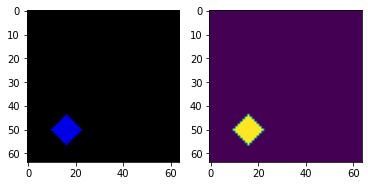

In [32]:
for sample in loader: break
imgs = sample["img"];masks = sample["masks"]
plt.subplot(121);plt.imshow(imgs[0].permute(1,2,0))
plt.savefig("outputs/input_image.png", bbox_inches='tight')
plt.subplot(122);plt.imshow(masks[0])
plt.savefig("outputs/gt_masks.png", bbox_inches='tight')

tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


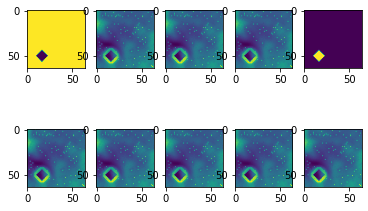

In [33]:
percept_outputs = model.perception(imgs, masks.unsqueeze(0).long())
all_masks = percept_outputs["masks"]
all_alives = percept_outputs["alive"]
for i in range(10):
    plt.subplot(2,5,1+i);plt.imshow(all_masks[0,:,:,i])
print(all_alives.flatten())

In [19]:
backbone_features = model.implementations["universal"](imgs)
b = 0
context = {
        "end":logit(all_alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
    }

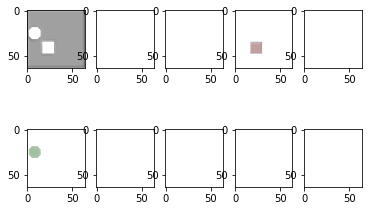

In [20]:
from rinarak.utils.tensor import stats_summary
"""Test the Expand Operator Works"""    
p = """(
            (Pr (color(expand (scene $0)) ) blue)
)
"""

p = Program.parse(p)
o = p.evaluate({0:context})
ends = o["end"].detach()
fig = plt.figure("ref-masks")
for i in range(ends.shape[0]):
    ax = fig.add_subplot(2,5,1+i)
    m = all_masks[b,:,:,i:i+1]
    #m = 1
    ax.imshow(m * imgs[b].permute(1,2,0)*ends[i].reshape([64,64,1]).sigmoid())

In [21]:
p = """
(
    intersect 
    (exists
        (intersect
            (Pr (color (expand (scene $0)) ) red) 
            (expand (scene $0))
        )
    )
    (scene $0)       
)
"""
p = Program.parse(p)
o = p.evaluate({0:context})
ends = o["end"].detach()
print(ends.sigmoid())

p = """
(
    intersect 
    (forall
        (union
            (Pr (color (expand (scene $0)) ) blue) 
            ( not (expand (scene $0)) )
        )
    )
    (scene $0)         
)
"""
p = Program.parse(p)
o = p.evaluate({0:context})
ends = o["end"].detach()
print(ends.sigmoid())

tensor([4.9384e-01, 1.0000e-06, 1.0000e-06, 3.4923e-01, 1.0000e-06, 5.0006e-01,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06])
tensor([2.7992e-01, 1.0000e-06, 1.0000e-06, 2.8186e-01, 1.0000e-06, 2.8525e-01,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06])


In [22]:
p1 = f"""(
    intersect 
    (forall
        (union
            (Pr (color (expand (scene $0)) ) {{}}) 
            ( not (expand (scene $0)) )
        )
    )
    (scene $0)         
)
"""
p2 = f"""(
    intersect 
    (exists
        (intersect
            (Pr (color (expand (scene $0)) ) {{}}) 
            (expand (scene $0))
        )
    )
    (scene $0)       
)
"""

In [23]:
backbone_features = model.implementations["universal"](imgs)
#print(backbone_features.shape)

In [27]:
import sys
for param in model.perception.parameters():
    param.requires_grad = False
for param in model.central_executor.parameters():
    param.requires_grad = True
optim = torch.optim.Adam(model.parameters(), lr = 2e-4)

outputs = model.perception(imgs, masks.long().unsqueeze(1))
backbone_features = outputs["features"]


for epoch in range(4000):
    b = 0
    backbone_features = model.implementations["universal"](imgs)
    context = {
        "end":logit(all_alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 2)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
    }
    
    loss = 0.0
    u1 = 5
    u2 = 3
    bi = 0

    # Forall Grounding
    o = Program.parse(p1.format("green")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u1]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u2]))

    o = Program.parse(p1.format("red")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u2]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u1]))
     
    # Existence Grounding
    o = Program.parse(p2.format("green")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u1]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u2]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][bi]))

    o = Program.parse(p2.format("red")).evaluate({0:context})
    loss -= torch.log(torch.sigmoid(o["end"][u2]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][u1]))
    loss -= torch.log(1 - torch.sigmoid(o["end"][bi]))


    optim.zero_grad()
    loss.backward()
    optim.step()
    vr=model.get_concept_embedding("green")
    vg=model.get_concept_embedding("red")
    sys.stdout.write(f"\repoch:{epoch} loss:{loss} cos:{torch.cosine_similarity(vr,vg)}")

epoch:454 loss:0.12476202845573425 cos:tensor([0.5929], grad_fn=<SumBackward1>)

KeyboardInterrupt: 

red


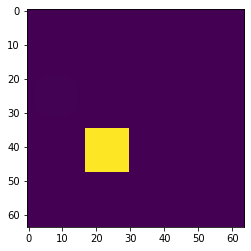

shape:[64, 64] max:4.432642459869385 min:-4.920410633087158
green


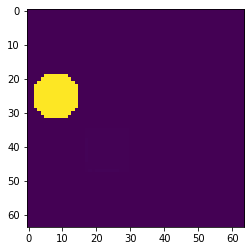

shape:[64, 64] max:4.383152961730957 min:-4.973934173583984
blue


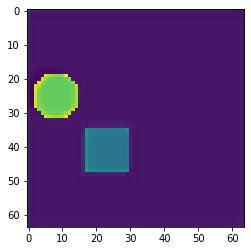

shape:[64, 64] max:0.21669864654541016 min:-1.3862025737762451
not-any-color


ValueError: 'not-any-color' is not in list

In [34]:
"""Evaluate the Property Map"""
from rinarak.utils.tensor import stats_summary
mapper = model.implementations["color"]
concept_feature_map = mapper(context["features"])
value_feature_maps = []
for value in ["red", "green", "blue","not-any-color"]:
    print(value)
    value_map = model.entailment(concept_feature_map, model.get_concept_embedding(value)).reshape([64,64])
    plt.imshow(value_map.sigmoid().detach())
    plt.show()
    stats_summary(value_map)